#### Goals and Objectives

Want to predict stock price valuations on a daily, weekly, monthly basis. We are given 2020 trading data and want to predict 2021 Q1 using that data. 

Recommend BUY, HOLD, SELL decisions while maximizing returns, minimizing losses, and minimizing HOLD periods.

Evaluate on basis of capital returns and use Bollinger Bands to measure systems effectiveness

#### Initial Thoughts

Since we do not have the hourly data, we will most likely use the % change column as our marker for buy, sell, hold. % change represents the daily change in closing prices.

Where a negative change means the closing price for that day is lower than it was yesterday, a positive change means it is higher than it was yesterday.

We can use ARIMA (autoregressive integrated moving average) in a time series analysis after checking that it is non stationary as time series forecasting only works on non stationary time series.



### EDA

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import re
%matplotlib inline

In [2]:
stocks = pd.ExcelFile("../data/2020Q1Q2Q3Q4-2021Q1.xlsx")

#### Russia

In [3]:
russia = pd.read_excel(stocks, 0)

In [4]:
russia.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,291.02,294,294.42,290.26,47.00M,-0.0076
1,2021-03-30 00:00:00,293.25,294.86,295.72,291.5,38.81M,-0.0002
2,2021-03-29 00:00:00,293.3,289.72,294.09,289.26,43.68M,0.0071
3,2021-03-26 00:00:00,291.22,288.63,292.75,288.32,56.07M,0.0159
4,2021-03-25 00:00:00,286.66,286.5,287.03,283.85,35.22M,0.0030


In [5]:
russia = russia.drop(311)

In [6]:
# reverse the list
russia = russia[::-1]

In [7]:
russia.head()

,Date,Price,Open,High,Low,Vol.,Change %
310,2020-01-03 00:00:00,255,255.99,258.19,253.7,35.85M,0.0010
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045
306,2020-01-10 00:00:00,258.19,257.86,259.25,256.88,18.85M,0.0008


In [8]:
date_2021 = datetime.strptime('2020-12-31', "%Y-%m-%d")
russia_test = russia[russia['Date'] > date_2021]
russia = russia[russia['Date'] <= date_2021]

In [9]:
print(russia.shape)
print(russia_test.shape)

(250, 7)
(61, 7)


In [10]:
russia.tail()

,Date,Price,Open,High,Low,Vol.,Change %
65,2020-12-24 00:00:00,269.32,271.98,272.82,267.13,42.61M,-0.0029
64,2020-12-25 00:00:00,270.64,269.97,271,268.28,11.99M,0.0049
63,2020-12-28 00:00:00,274.7,270.9,275.19,269.73,39.04M,0.0150
62,2020-12-29 00:00:00,272,275.91,276.43,271.26,39.02M,-0.0098
61,2020-12-30 00:00:00,271.65,272.49,274.24,270.12,31.53M,-0.0013


(array([18262., 18322., 18383., 18444., 18506., 18567., 18628.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

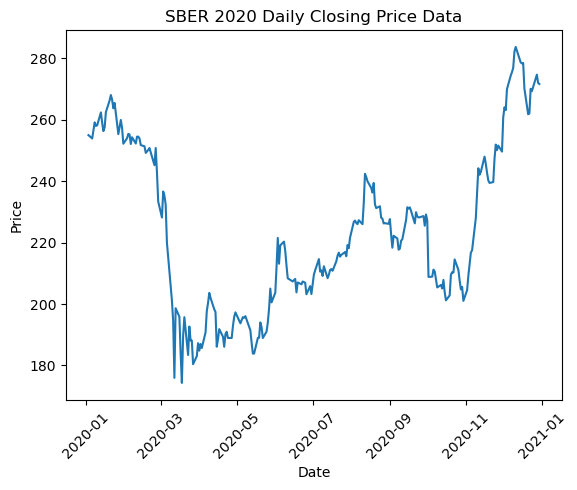

In [11]:
sns.lineplot(data=russia, x='Date', y ='Price')
plt.title('SBER 2020 Daily Closing Price Data')
plt.xticks(rotation=45)

In [12]:
plt.figure(figsize=(24,16))
fig = go.Figure(data=[go.Candlestick(x=russia['Date'], 
                open=russia['Open'],
                high = russia['High'],
                low = russia['Low'],
                close = russia['Price'])])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

<Figure size 2400x1600 with 0 Axes>

In [13]:
russia['Vol.'] = russia['Vol.'].apply(lambda x: float(re.sub('M', "", x)) * 1000000)

In [14]:
russia.head()

,Date,Price,Open,High,Low,Vol.,Change %
310,2020-01-03 00:00:00,255,255.99,258.19,253.7,35850000.0,0.0010
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22350000.0,-0.0043
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40820000.0,0.0207
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38330000.0,-0.0045
306,2020-01-10 00:00:00,258.19,257.86,259.25,256.88,18850000.0,0.0008


In [54]:
# when changing the data into weekly/monthly,
# we can keep everything the same except for the % change where it should change according to the difference between weekly/monthly closing prices
logic = {'Open'  : 'first',
         'High'  : 'max',
         'Low'   : 'min',
         'Price' : 'last',
         'Vol.': 'sum',
         'Change %': 'sum'}

russia_weekly = russia.set_index('Date')
russia_weekly = russia_weekly.sort_index()
russia_weekly = russia_weekly.resample('W').apply(logic)
russia_weekly.index = russia_weekly.index - pd.tseries.frequencies.to_offset("6D")
russia_weekly = russia_weekly.reset_index()

In [55]:
russia_weekly['Vol.'] = russia_weekly['Vol.'].apply(lambda x: str(x/1000000) + "M")

In [56]:
russia_weekly.head()

,Date,Open,High,Low,Price,Vol.,Change %
0,2019-12-30,255.99,258.19,253.70,255,35.85M,0.0010
1,2020-01-06,254.75,261.76,251.40,258.19,120.35M,0.0127
2,2020-01-13,258.3,263.22,254.21,262.5,191.51M,0.0170
3,2020-01-20,263.2,270.80,261.80,265.49,180.1M,0.0116
4,2020-01-27,261,262.10,252.17,252.2,219.33M,-0.0503


In [60]:
logic = {'Open'  : 'first',
         'High'  : 'max',
         'Low'   : 'min',
         'Price' : 'last',
         'Vol.': 'sum',
         'Change %': 'sum'}

russia_monthly = russia.set_index('Date')
russia_monthly = russia_monthly.sort_index()
russia_monthly = russia_monthly.resample('M').apply(logic)
russia_monthly.index = russia_monthly.index - pd.tseries.frequencies.to_offset("M")
russia_monthly = russia_monthly.reset_index()

In [61]:
russia_monthly['Vol.'] = russia_monthly['Vol.'].apply(lambda x: str(x/1000000) + "M")

In [62]:
russia_monthly.head()

,Date,Open,High,Low,Price,Vol.,Change %
0,2019-12-31,255.99,270.80,251.40,252.2,747.14M,-0.0080
1,2020-01-31,251.8,259.77,231.00,233.36,919.84M,-0.0754
2,2020-02-29,238.93,241.00,172.15,187.21,3001.72M,-0.1884
3,2020-03-31,183.2,205.44,182.00,197.25,1768.2M,0.0566
4,2020-04-30,195.68,205.00,183.33,200.5,1359.04M,0.0192


From https://tcoil.info/compute-bollinger-bands-for-stocks-with-python-and-pandas/

In [63]:
def bollinger_bands(df, n, m):
    # takes dataframe on input
    # n = smoothing length
    # m = number of standard deviations away from MA
    
    #typical price
    TP = (df['High'] + df['Low'] + df['Price']) / 3
    # but we will use Adj close instead for now, depends
    
    data = TP
    #data = df['Adj Close']
    
    # takes one column from dataframe
    B_MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='B_MA')
    sigma = data.rolling(n, min_periods=n).std() 
    
    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')
    
    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)
    
    return df

In [64]:
russia_bollinger = bollinger_bands(russia, 20, 2)

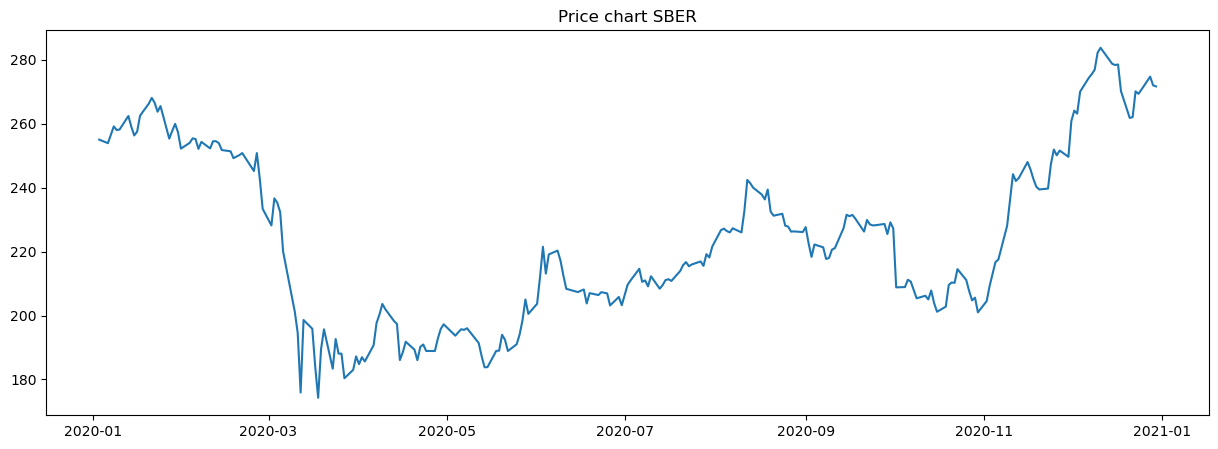

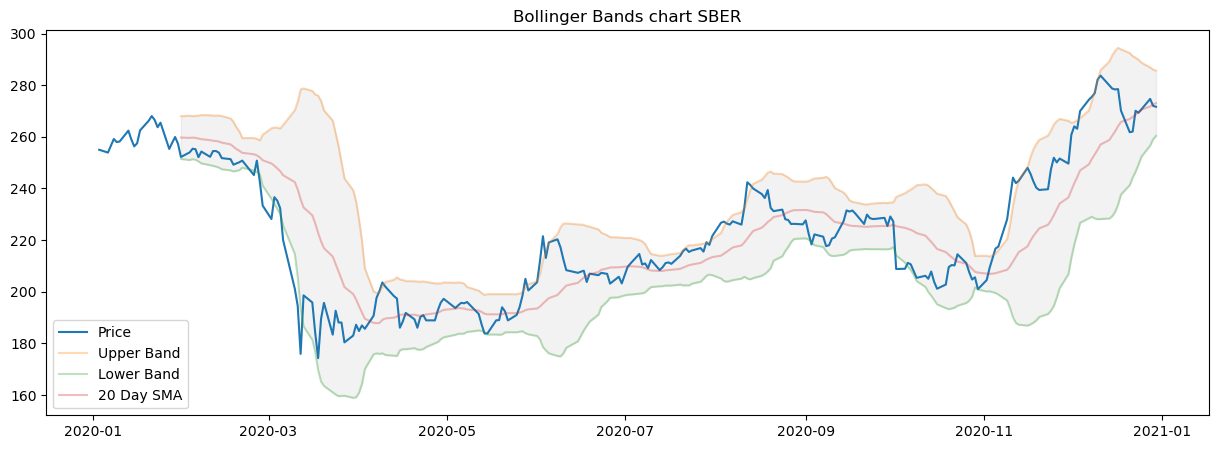

In [65]:
# plot price
plt.figure(figsize=(15,5))
plt.plot(russia_bollinger['Date'], russia_bollinger['Price'])
plt.title('Price chart ' + "SBER")
plt.show()

# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('Bollinger Bands chart ' + "SBER")
plt.plot(russia_bollinger['Date'], russia_bollinger['Price'], label = "Price")
plt.plot(russia_bollinger['Date'], russia_bollinger['BU'], alpha=0.3, label = "Upper Band")
plt.plot(russia_bollinger['Date'], russia_bollinger['BL'], alpha=0.3, label = "Lower Band")
plt.plot(russia_bollinger['Date'], russia_bollinger['B_MA'], alpha=0.3, label = "20 Day SMA")
plt.fill_between(russia_bollinger['Date'], russia_bollinger['BU'], russia_bollinger['BL'], color='grey', alpha=0.1)
plt.legend()

plt.show()

In [82]:
import numpy as np
def add_signal(df):
    # adds two columns to dataframe with buy and sell signals
    buy_list = []
    sell_list = []
    
    for i in range(len(df['Price'])):
        if df['Price'][i] > df['BU'][i]:           # sell signal     daily
        # if df['High'][i] > df['BU'][i]:             # sell signal     weekly
            buy_list.append(np.nan)
            sell_list.append(df['Price'][i])
        elif df['Price'][i] < df['BL'][i]:         # buy signal      daily
        # elif df['Low'][i] < df['BL'][i]:            # buy signal      weekly
            buy_list.append(df['Price'][i])
            sell_list.append(np.nan)  
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
         
    buy_list = pd.Series(buy_list, name='Buy')
    sell_list = pd.Series(sell_list, name='Sell')
        
    df = df.join(buy_list)
    df = df.join(sell_list)        
     
    return df

In [83]:
def plot_signals(df, ticker):
    # plot price
    plt.figure(figsize=(15,5))
    plt.plot(df['Date'], df['Price'])
    plt.title('Price chart ' + str(ticker))
    plt.show()

    # plot  values and significant levels
    plt.figure(figsize=(15,5))
    plt.title('Bollinger Bands chart ' + str(ticker))
    plt.plot(df['Date'], df['Price'], label='Adj Close')

    plt.plot(df['Date'], df['High'], label='High', alpha=0.3)
    plt.plot(df['Date'], df['Low'], label='Low', alpha=0.3)

    plt.plot(df['Date'], df['BU'], label='B_Upper', alpha=0.3)
    plt.plot(df['Date'], df['BL'], label='B_Lower', alpha=0.3)
    plt.plot(df['Date'], df['B_MA'], label='B_SMA', alpha=0.3)
    plt.fill_between(df['Date'], df['BU'], df['BL'], color='grey', alpha=0.1)

    plt.scatter(df['Date'], df['Buy'], label='Buy', marker='^')
    plt.scatter(df['Date'], df['Sell'], label='Sell', marker='v')

    plt.legend()

    plt.show()

In [84]:
russia

,Date,Price,Open,High,Low,Vol.,Change %
310,2020-01-03 00:00:00,255,255.99,258.19,253.7,35850000.0,0.0010
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22350000.0,-0.0043
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40820000.0,0.0207
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38330000.0,-0.0045
306,2020-01-10 00:00:00,258.19,257.86,259.25,256.88,18850000.0,0.0008
...,...,...,...,...,...,...,...
65,2020-12-24 00:00:00,269.32,271.98,272.82,267.13,42610000.0,-0.0029
64,2020-12-25 00:00:00,270.64,269.97,271,268.28,11990000.0,0.0049
63,2020-12-28 00:00:00,274.7,270.9,275.19,269.73,39040000.0,0.0150
62,2020-12-29 00:00:00,272,275.91,276.43,271.26,39020000.0,-0.0098


In [89]:
russia_daily_bollinger = bollinger_bands(russia, 20, 2)
russia_daily_bollinger = add_signal(russia_daily_bollinger)
plot_signals(russia_daily_bollinger, "SBER")

KeyError: 0

In [73]:
russia_weekly_bollinger = bollinger_bands(russia_weekly, 20, 2)
russia_weekly_bollinger = add_signal(russia_weekly_bollinger)

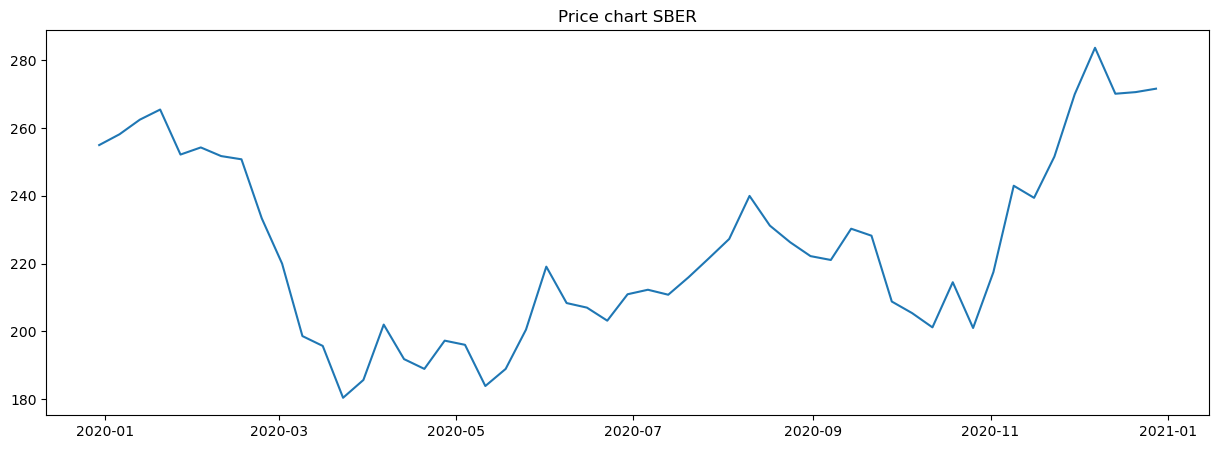

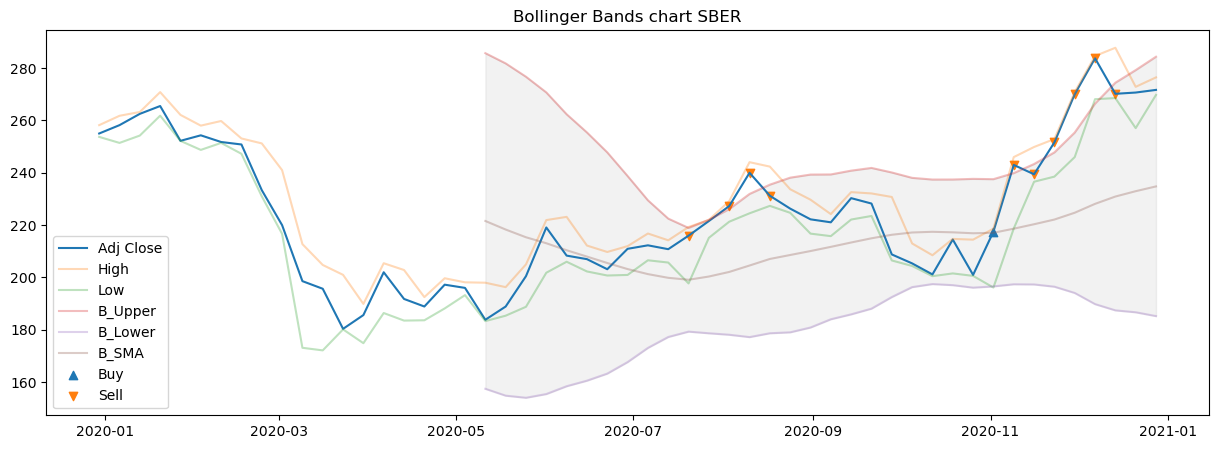

In [74]:
plot_signals(russia_weekly_bollinger, "SBER")

From my understanding of BBands, when the Price hits the upper threshold we sell, when it hits the lower threshold we buy.

Then we are holding during the periods where the price is inbetween the upper and lower BBand.

##### Time Series

In [ ]:
# time series forecasting
# use ADF to test for stationarity
from statsmodels.tsa.stattools import adfuller
def ADF_Stationarity_Test(time, alpha):
    '''
    Takes time series and alpha (significance level) and 
    prints the adfuller test result
    print the conclusion of statonarity based on ADF
    '''
    result = adfuller(time['Price'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')  
    if result[1] > alpha:
        print('We accept the null hypothesis, the time series has a unit root and is not stationary.')
    else:
        print('We reject the null hypothesis, the time series does not have a unit root and is stationary.')

In [ ]:
ADF_Stationarity_Test(russia, 0.05)

ADF Statistic: -1.423324
p-value: 0.571045
Critial Values:
   1%, -3.4577787098622674
Critial Values:
   5%, -2.873608704758507
Critial Values:
   10%, -2.573201765981991
We accept the null hypothesis, the time series has a unit root and is not stationary.


In [ ]:
X = russia['Price']
test_size = russia_test.shape[0]

In [ ]:
print(X)

310       255
309     253.9
308    259.15
307    257.99
306    258.19
        ...  
65     269.32
64     270.64
63      274.7
62        272
61     271.65
Name: Price, Length: 250, dtype: object


In [ ]:
russia.iloc[0]

Date        2020-01-03 00:00:00
Price                       255
Open                     255.99
High                     258.19
Low                       253.7
Vol.                 35850000.0
Change %                  0.001
Name: 310, dtype: object

In [ ]:
russia.iloc[-1]

Date        2020-12-30 00:00:00
Price                    271.65
Open                     272.49
High                     274.24
Low                      270.12
Vol.                 31530000.0
Change %                -0.0013
Name: 61, dtype: object

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_squared_error
history = [x for x in X]
predictions = list()
# iteration step for each time point
for time_point in range(test_size):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	predicted= output[0]
	predictions.append(predicted)
	obs = russia_test.iloc[time_point]['Price']
	history.append(obs)
	print('predicted=%f, expected=%f' % (predicted, obs))
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(russia_test['Price'], predictions))
print('Test RMSE: %.3f' % rmse)

predicted=271.982294, expected=272.000000
predicted=272.603643, expected=275.200000
predicted=274.905086, expected=272.930000
predicted=272.651366, expected=283.640000
predicted=284.202923, expected=289.490000
predicted=289.772735, expected=289.990000
predicted=289.496573, expected=283.780000
predicted=285.115995, expected=284.790000
predicted=285.868785, expected=276.900000
predicted=276.405247, expected=279.790000
predicted=279.287082, expected=278.190000
predicted=278.375577, expected=279.800000
predicted=278.718417, expected=274.400000
predicted=274.797687, expected=268.250000
predicted=267.850684, expected=265.300000
predicted=265.684114, expected=269.340000
predicted=268.865852, expected=265.500000
predicted=264.398627, expected=265.960000
predicted=265.767378, expected=258.110000
predicted=258.502564, expected=263.800000
predicted=263.526587, expected=263.150000
predicted=263.265655, expected=263.530000
predicted=262.194241, expected=270.110000
predicted=271.325019, expected=271

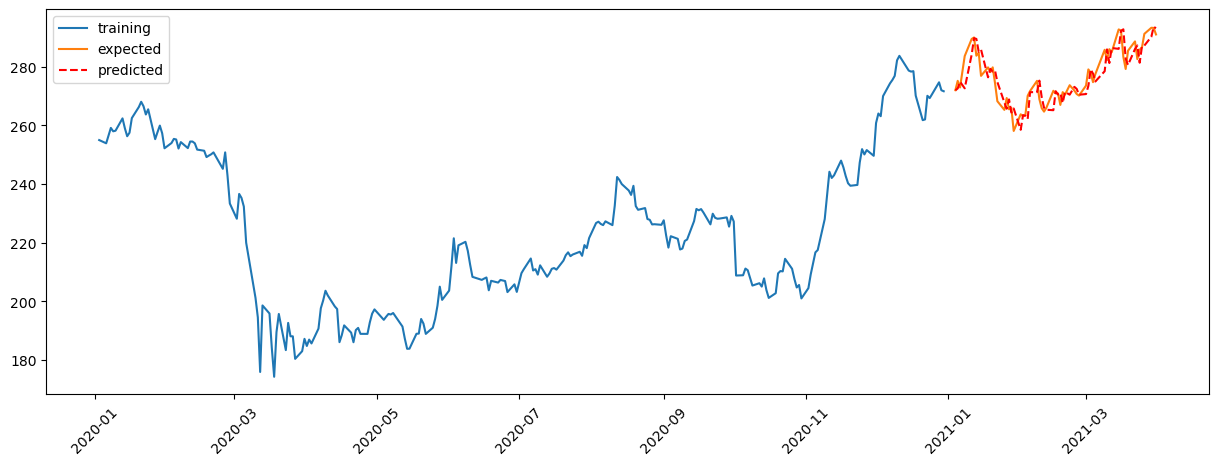

In [ ]:
# plot forecasts against actual outcomes
plt.figure(figsize=(15,5))
plt.plot(russia['Date'], russia['Price'].values, label='training')
plt.plot(russia_test['Date'], russia_test['Price'].values, label='expected')
plt.plot(russia_test['Date'], predictions, color='red', linestyle='dashed', label='predicted')
plt.xticks(rotation=45)
plt.legend()
plt.show()